In [1]:
%load_ext autoreload
%autoreload 2

In [108]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, stats
import pandas as pd
from astropy import table, coordinates
from astropy import units as u
from astropy.io import fits
from astropy import cosmology
import sep
from astrodendro import Dendrogram

from ekfplot import plot as ek
from ekfplot import colors as ec
from ekfphys import observer
from ekfstats import imstats, fit, sampling, functions

from carpenter import conventions

import reader

In [3]:
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

merian = table.Table(fits.getdata('../local_data/inputs/Merian_DR1_photoz_EAZY_v1.2.fits',1))
mcoords = coordinates.SkyCoord( merian['coord_ra_Merian'], merian['coord_dec_Merian'], unit='deg')
merian_sources, galex = reader.get_meriancrossgalex (merian)

[merianselect] Only choosing sources at 0.070<z_phot<0.090
[merianselect] Only choosing sources with i_cModelmag_Merian < 22.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


In [100]:
catalog_halum = pd.read_csv ( '/Users/kadofong/Desktop/merian_catalog_halum.csv', index_col=0)
merian_lha_df = pd.read_csv('../local_data/output/lha_df.csv', index_col=0).dropna()
#merian_lha_df = merian_lha_df.reindex(merian_sources.index)

In [101]:
fn = lambda x: conventions.produce_merianobjectname(x['RA'], x['DEC'], )
merian_sources['objname'] = merian_sources.apply(fn, axis=1)

In [ ]:
sbdf = pd.DataFrame(
    index=merian_lha_df.index,
    columns=['r_eff','n','r_eff_psf','n_psf']
)


for mid in merian_sources.index:
    row = merian_sources.loc[mid]
    wid = conventions.produce_merianobjectname(
        ra=merian_sources.loc[mid,'RA'],
        dec=merian_sources.loc[mid,'DEC']
    )

    #print(merian_sources.loc[mid,'RA'],merian_sources.loc[mid,'DEC'])
    redshift = row['z_phot']
    filename = f'/Users/kadofong/work/projects/merian/agrias/local_data/cutouts/halpha/{wid}.fits'
    if not os.path.exists(filename):
        continue
    
    x = fits.open(filename)
    img = x[0].data.astype(np.float64)
    
    psf = fits.open('../local_data/cutouts/merian/J000004.79+003359.58_N708_merpsf.fits')[0].data
    
    i_std = np.std(stats.sigmaclip(functions.fmasker(img)[0]).clipped)
    #ek.imshow(np.where(segmap>0, np.random.normal(0.,i_std,img.shape), img))
    
    #cat, segmap = sep.extract(img, thresh=3, err=i_std, deblend_cont=1., segmentation_map=True)
    #centralid = imstats.get_centerval(segmap)
    
    pixscale = 0.168 * u.arcsec
    sky_to_phys = (pixscale * cosmo.kpc_proper_per_arcmin(redshift)).to(u.kpc).value
    init_r_eff = 1./sky_to_phys
    model, pred = fit.fit_sersic_2d(img, init_r_eff=init_r_eff )
    model
    
    Y,X = np.mgrid[:img.shape[0],:img.shape[1]]
    X_c = (X - model.x_0)
    Y_c = (Y - model.y_0)
    X_rot, Y_rot = imstats.rotate_coordinates( X_c, Y_c, np.pi-model.theta )
    Y_rot /=  1. - model.ellip
    R = np.sqrt(X_rot**2 + Y_rot**2) + 0.0001
    
    R_phys = R*sky_to_phys
    
    R_psf = imstats.build_xygrid(psf.shape) * sky_to_phys
    
    gr = -2.5*np.log10(row['g_gaap1p0Flux_aperCorr_Merian']/row['r_gaap1p0Flux_aperCorr_Merian'])
    apercorr = row['i_cModelFlux_Merian']/row['i_gaap1p0Flux_aperCorr_Merian']
    rmag = -2.5*np.log10(row['r_gaap1p0Flux_aperCorr_Merian'] * apercorr) + 31.4
    Mr = rmag - observer.photometric_kcorrection(gr,redshift) - cosmo.distmod(redshift).value
    
    fig, axarr = plt.subplots(1,2,figsize=(12,5))
    
    ax = axarr[0]
    ek.imshow(img, q=5e-3, ax=ax, cmap='magma')
    ek.contour(R_phys, colors='w', linestyles=':', levels=np.array([1.,5., 10.]), ax=ax)#labels=['1','5','10'])
    ek.text(
        0.025,
        0.975,
        r'''${\rm log_{10}(M_\star/M_\odot)=%.2f}$
$M_r = %.1f$''' % (row['logmass_gaap1p0'],Mr),
        color='w',
        ax=ax
    )
    ax.set_xlim(50,200)
    ax.set_ylim(50,200)

    _rbins = np.arange(2.,40.,1)
    rbins = _rbins  * sky_to_phys
    
    bx = axarr[1]
    _,(cts,_,patches) = ek.hist(
        R_phys,
        weights=(img/(2.*np.pi*R_phys)).flatten(), 
        bins=rbins,
        alpha=0.1,
        lw=2,
        ax=bx
    )
    
    psf_cts,_=np.histogram(
        R_psf.flatten(),
        weights=(psf/(2.*np.pi*R_psf)).flatten(),
        bins=rbins,
    )
    
    psf_normalizer = np.nanmax(cts)/np.nanmax(psf_cts)
    ek.hist(
        R_psf.flatten(),
        weights=(psf_normalizer*psf/(2.*np.pi*R_psf)).flatten(),
        bins=rbins,
        histtype='step',
        lw=2,
        color='grey',
        zorder=0,
        ax=bx
    )

    npix = np.pi*(_rbins[1:]**2-_rbins[:-1]**2)
    bx.plot(sampling.midpts(rbins), i_std/np.sqrt(npix), color='k')
    bx.axhline(i_std, color='k')
    bx.set_yscale('log')
    bx.set_ylim( i_std/np.sqrt(npix.max()), plt.ylim()[1])
    bx.set_xlabel('a [kpc]')
    bx.set_ylabel(r'SB$_{\rm H\alpha}$ [erg s$^{-1}$ kpc$^{-2}$]')

    rmid = sampling.midpts(rbins)
    try:
        s1d_model, s1d_pred = fit.fit_sersic_1d(*functions.fmasker(rmid, cts), 
                                                init_r_eff=2., init_const=i_std)
        psf_model, psf_pred = fit.fit_sersic_1d(*functions.fmasker(rmid, psf_cts*psf_normalizer), 
                                                init_r_eff=0.5, init_const=i_std)
        sbdf.loc[mid, 'r_eff'] = s1d_model.r_eff_0.value
        sbdf.loc[mid, 'n'] = s1d_model.n_0.value
        sbdf.loc[mid, 'r_eff_psf'] = psf_model.r_eff_0.value
        sbdf.loc[mid, 'n_psf'] = psf_model.n_0.value  

        sbdf.loc[mid, 'A'] = np.log10(s1d_pred[0])
        sbdf.loc[mid, 'i_std'] = np.log10(i_std)

        bx.plot ( functions.fmasker(rmid, cts)[0], s1d_pred, color='C0', lw=3 )
        bx.plot ( functions.fmasker(rmid, psf_cts)[0], psf_pred, color='grey', lw=3 )
        bx.axvline ( s1d_model.r_eff_0.value, color='C0', ls='--', lw=3 )
        bx.axvline ( psf_model.r_eff_0.value, color='grey', ls='--', lw=1.5 )
        #bx.set_xlim(0., functions.fmasker(rmid, cts)[0].max())

        ek.contour(R_phys, colors=ec.ColorBase('C0').modulate(0.2,0.3).hex_base, levels=np.array([s1d_model.r_eff_0.value]), ax=ax)

    except:
        pass

    plt.savefig(f'/Users/kadofong/Desktop/figures/{mid}.png')
    plt.close()
    #print(f'Processed {mid}')

sbdf['snr'] = 10.**(sbdf['A'] - sbdf['i_std'])

/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/astropy/modeling/functional_models.py:3292: RuntimeWarning: divide by zero encountered in divide
  z = np.sqrt((x_maj / a) ** 2 + (x_min / b) ** 2)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/astropy/modeling/functional_models.py:858: RuntimeWarning: divide by zero encountered in divide
  -cls._gammaincinv(2 * n, 0.5) * ((r / r_eff) ** (1 / n) - 1)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_72721/2863054804.py:88: RuntimeWarning: All-NaN slice encountered
  psf_normalizer = np.nanmax(cts)/np.nanmax(psf_cts)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/astropy/modeling/functional_models.py:3292: RuntimeWarning: divide by zero encountered in divide
  z = np.sqrt((x_maj / a) ** 2 + (x_min / b) ** 2)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/astropy/modeling/functional_models.py:858: RuntimeWarning: divide by zero e

In [191]:
sbdf.dropna()

,r_eff,n,r_eff_psf,n_psf,A,i_std,snr
M3324848395603966290,5.506393,0.5,1.632478,10.0,36.756827,37.155378,0.399438


In [153]:
extended = (sbdf['A']/sbdf['i_std'] > 3.)&(sbdf['n']>0.5)&(sbdf['n']<4.)&(sbdf['r_eff']>sbdf['r_eff_psf'])

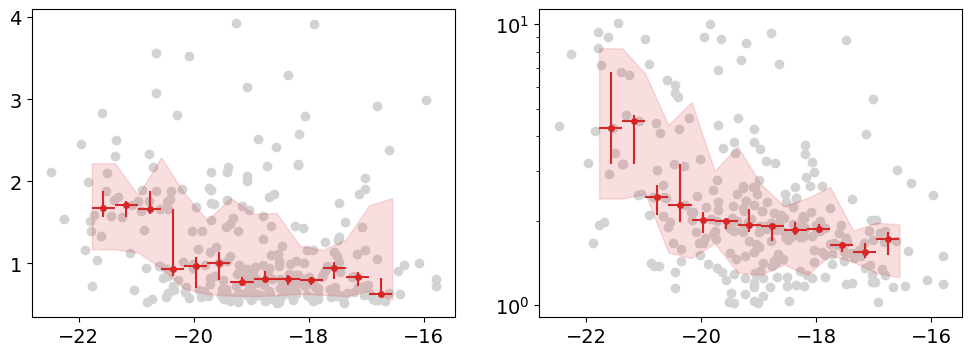

In [169]:
fig, axarr = plt.subplots(1,2,figsize=(12,4))

ax = axarr[0]
im = ax.scatter(
    #merian_sources.reindex(sbdf.index).loc[extended, 'i_cModelmag_Merian'],    
    merian_sources.reindex(sbdf.index).loc[extended, 'Mi'],
    sbdf.loc[extended,'n'],
    color='lightgrey',
)
ek.running_quantile(
    merian_sources.reindex(sbdf.index).loc[extended, 'Mi'],
    sbdf.loc[extended,'n'],
    bins=14,
    ax=ax,
    erronqt=True,
    color='tab:red'
)

ax = axarr[1]
im = ax.scatter(
    #merian_sources.reindex(sbdf.index).loc[extended, 'i_cModelmag_Merian'],    
    merian_sources.reindex(sbdf.index).loc[extended, 'Mi'],
    sbdf.loc[extended,'r_eff'],
    color='lightgrey',
)
ek.running_quantile(
    merian_sources.reindex(sbdf.index).loc[extended, 'Mi'],
    sbdf.loc[extended,'r_eff'],
    bins=14,
    ax=ax,
    erronqt=True,
    color='tab:red'
)
ax.set_yscale('log')
#plt.colorbar(im, ax=ax, label=r'$M_i$')
#ax.set_ylim(0.,2.5)

In [172]:
row = sbdf.loc['M3037018241684749214']
print(np.log10(row.A))

37.44777423669638


In [256]:
froma astropy.modeling.models import Sersic1D, Const1D

In [263]:
rmask = R_phys < 15.
s1d_model, s1d_pred = fit.fit_sersic_1d(R_phys[rmask], img[rmask], init_r_eff=2., init_const=i_std)
psf_model, psf_pred = fit.fit_sersic_1d(R_psf, psf, init_r_eff=0.5, init_const=i_std)

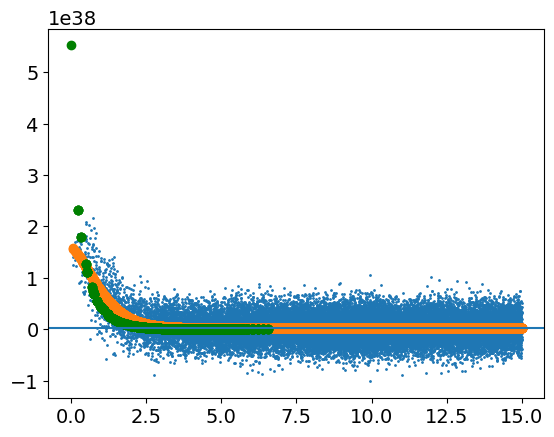

In [302]:
out = R_phys > 5.
plt.scatter ( R_phys[rmask], img[rmask], s=1)
plt.scatter ( R_phys[rmask], s1d_pred)
plt.scatter ( R_psf.flatten(), psf_pred.flatten()*s1d_model.amplitude_0/psf_model.amplitude_0, color='g')
plt.axhline(np.median(img[out]))
#plt.yscale('log')